# Clustering of Bank_Transaction_clean.csv

# Set Up PySpark

In [48]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'

In [49]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HierarchicalClustering").enableHiveSupport().getOrCreate()

# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

# Importing Libraries

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import BisectingKMeans

# Load the Data

In [4]:
data = spark.read.csv("file:///home/talentum/shared/C-DAC_Project/Bank_Transaction_clean.csv", header=True, inferSchema=True)

In [5]:
data.show(5)

+-------------+----------+----------+------------------+-------------------+--------------------+-----------+------------+
|TransactionID|CustomerID|CustGender|CustAccountBalance|    TransactionDate|TransactionAmountINR|CustomerAge|CustLocation|
+-------------+----------+----------+------------------+-------------------+--------------------+-----------+------------+
|           T1|  C5841053|         F|          17819.05|2016-08-02 00:00:00|                25.0|         22|  JAMSHEDPUR|
|           T3|  C4417068|         F|          17874.44|2016-08-02 00:00:00|               459.0|         19|      MUMBAI|
|           T4|  C5342380|         F|          866503.2|2016-08-02 00:00:00|              2060.0|         43|      MUMBAI|
|           T5|  C9031234|         F|           6714.43|2016-08-02 00:00:00|              1762.5|         28|      MUMBAI|
|           T6|  C1536588|         F|           53609.2|2016-08-02 00:00:00|               676.0|         44|    ITANAGAR|
+-------------+-

In [6]:
# Count the number of rows and columns
row_count = data.count()
column_count = len(data.columns)
print(row_count,column_count)

917533 8


# -----------------------------------Hierarchical Clustering-------------------------------------

# Feature Selection
#Select the features that you want to use for clustering. For this example, we'll use:

#CustAccountBalance
#TransactionAmountINR
#CustomerAge

In [7]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Select relevant numerical features for clustering
feature_columns = ['CustAccountBalance', 'TransactionAmountINR', 'CustomerAge']

In [8]:
# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(data)

# Standardize the features

In [9]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [10]:
# Show the scaled data
scaled_data.select("scaledFeatures").show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[-0.1525368065267...|
|[-0.1524116923635...|
|[1.76445917186732...|
|[-0.1776197680520...|
|[-0.0716945124694...|
+--------------------+
only showing top 5 rows



# Split the data into training and test sets

In [11]:
# Split the data into training and test sets
train_data, test_data = scaled_data.randomSplit([0.8, 0.2], seed=1234)

# Show the count of each dataset
print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 734368
Test Data Count: 183165


# Perform Hierarchical Clustering using PySpark k=3

#Apply BisectingKMeans for hierarchical clustering on the training data

In [12]:
from pyspark.ml.clustering import BisectingKMeans

# Apply BisectingKMeans for hierarchical clustering on the training data
bkmeans = BisectingKMeans(k=3, featuresCol="scaledFeatures", seed=1)
model = bkmeans.fit(train_data)

In [13]:
# Make predictions on the test data
predictions = model.transform(test_data)

In [14]:
# Evaluate clustering by computing Within Set Sum of Squared Errors (WSSSE)
wssse = model.computeCost(test_data)
print(f"Within Set Sum of Squared Errors = {wssse}")

Within Set Sum of Squared Errors = 516457.1109158634


In [15]:
# Show some of the predictions
predictions.select("TransactionID", "CustomerID", "prediction").show(5)

+-------------+----------+----------+
|TransactionID|CustomerID|prediction|
+-------------+----------+----------+
|           T1|  C5841053|         0|
|          T10|  C6638934|         2|
|         T100|  C1713934|         2|
|      T100008|  C8632241|         1|
|      T100020|  C2466557|         2|
+-------------+----------+----------+
only showing top 5 rows



# Evaluate the Model

In [16]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score = {silhouette}")

Silhouette Score = 0.1774224231267608


In [17]:
# Silhouette Score = 0.1774224231267608
# means clusters are overlapping
# not a really good segmentation

# Visualizing the Cluster Centers

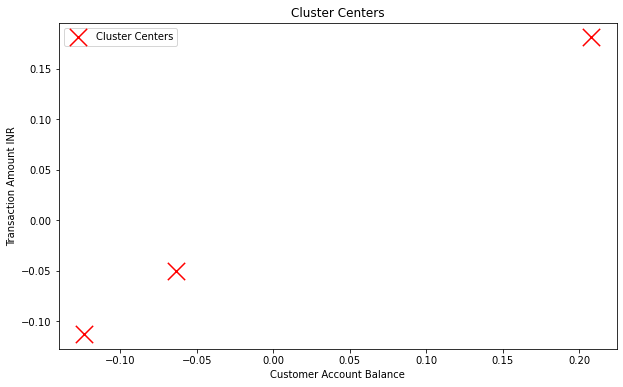

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the cluster centers from the model
centers = model.clusterCenters()

# Convert the centers to a Pandas DataFrame for easier plotting
centers_df = pd.DataFrame(centers, columns=feature_columns)

# Plot the cluster centers
plt.figure(figsize=(10, 6))
plt.scatter(centers_df['CustAccountBalance'], centers_df['TransactionAmountINR'], 
            s=300, c='red', marker='x', label='Cluster Centers')
plt.xlabel('Customer Account Balance')
plt.ylabel('Transaction Amount INR')
plt.title('Cluster Centers')
plt.legend()
plt.show()

# Perform Hierarchical Clustering using PySpark k=4

In [19]:
from pyspark.ml.clustering import BisectingKMeans

bkmeans = BisectingKMeans(k=4, featuresCol="scaledFeatures", seed=1)
model = bkmeans.fit(train_data)

In [20]:
#Make predictions on the test data
predictions = model.transform(test_data)

In [21]:
#Evaluate clustering by computing Within Set Sum of Squared Errors (WSSSE)
wssse = model.computeCost(test_data)
print(f"Within Set Sum of Squared Errors = {wssse}")

Within Set Sum of Squared Errors = 421785.46341206576


In [22]:
# Show some of the predictions
predictions.select("TransactionID", "CustomerID", "prediction").show(5)

+-------------+----------+----------+
|TransactionID|CustomerID|prediction|
+-------------+----------+----------+
|           T1|  C5841053|         0|
|          T10|  C6638934|         2|
|         T100|  C1713934|         2|
|      T100008|  C8632241|         1|
|      T100020|  C2466557|         2|
+-------------+----------+----------+
only showing top 5 rows



In [23]:
#Evaluate the Model when k=4
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score = {silhouette}")

Silhouette Score = 0.3844893147205863


In [24]:
# Silhouette Score = 0.3844893147205863~0.4
# means clustering has a moderate level of quality
# Average segmentation

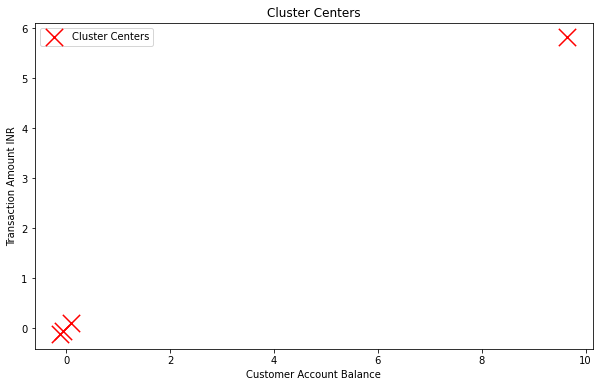

In [25]:
# Visual Represetation
# Get the cluster centers from the model
centers = model.clusterCenters()

# Convert the centers to a Pandas DataFrame for easier plotting
centers_df = pd.DataFrame(centers, columns=feature_columns)

# Plot the cluster centers
plt.figure(figsize=(10, 6))
plt.scatter(centers_df['CustAccountBalance'], centers_df['TransactionAmountINR'], 
            s=300, c='red', marker='x', label='Cluster Centers')
plt.xlabel('Customer Account Balance')
plt.ylabel('Transaction Amount INR')
plt.title('Cluster Centers')
plt.legend()
plt.show()

# Perform Hierarchical Clustering using PySpark k=5

In [26]:
from pyspark.ml.clustering import BisectingKMeans

# Apply BisectingKMeans for hierarchical clustering on the training data
bkmeans = BisectingKMeans(k=5, featuresCol="scaledFeatures", seed=1)
model = bkmeans.fit(train_data)

In [27]:
# Make predictions on the test data
predictions = model.transform(test_data)

In [28]:
# Evaluate clustering by computing Within Set Sum of Squared Errors (WSSSE)
wssse = model.computeCost(test_data)
print(f"Within Set Sum of Squared Errors = {wssse}")

Within Set Sum of Squared Errors = 416709.6227938428


In [29]:
# Show some of the predictions
predictions.select("TransactionID", "CustomerID", "prediction").show(5)

+-------------+----------+----------+
|TransactionID|CustomerID|prediction|
+-------------+----------+----------+
|           T1|  C5841053|         0|
|          T10|  C6638934|         3|
|         T100|  C1713934|         3|
|      T100008|  C8632241|         2|
|      T100020|  C2466557|         3|
+-------------+----------+----------+
only showing top 5 rows



In [30]:
#Evaluate the Model
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score = {silhouette}")

Silhouette Score = 0.22922364032328763


In [31]:
# Silhouette Score = 0.22922364032328763
# means some clusters are little overlapping
# not a really good segmentation

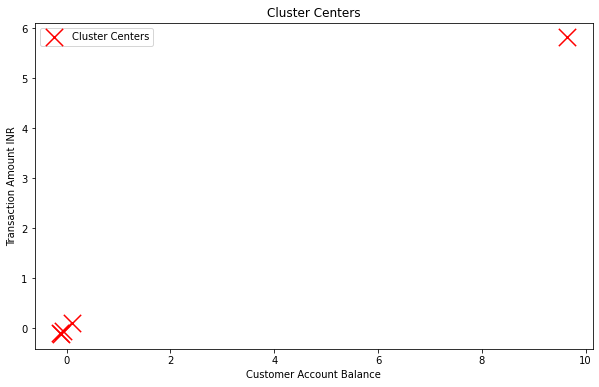

In [32]:
# Visual Represetation
# Get the cluster centers from the model
centers = model.clusterCenters()

# Convert the centers to a Pandas DataFrame for easier plotting
centers_df = pd.DataFrame(centers, columns=feature_columns)

# Plot the cluster centers
plt.figure(figsize=(10, 6))
plt.scatter(centers_df['CustAccountBalance'], centers_df['TransactionAmountINR'], 
            s=300, c='red', marker='x', label='Cluster Centers')
plt.xlabel('Customer Account Balance')
plt.ylabel('Transaction Amount INR')
plt.title('Cluster Centers')
plt.legend()
plt.show()

# Perform Hierarchical Clustering using PySpark k=6

In [33]:
from pyspark.ml.clustering import BisectingKMeans

# Apply BisectingKMeans for hierarchical clustering on the training data
bkmeans = BisectingKMeans(k=6, featuresCol="scaledFeatures", seed=1)
model = bkmeans.fit(train_data)

In [34]:
# Make predictions on the test data
predictions = model.transform(test_data)

In [35]:
# Evaluate clustering by computing Within Set Sum of Squared Errors (WSSSE)
wssse = model.computeCost(test_data)
print(f"Within Set Sum of Squared Errors = {wssse}")

Within Set Sum of Squared Errors = 389168.6443254269


In [36]:
# Show some of the predictions
predictions.select("TransactionID", "CustomerID", "prediction").show(5)

+-------------+----------+----------+
|TransactionID|CustomerID|prediction|
+-------------+----------+----------+
|           T1|  C5841053|         0|
|          T10|  C6638934|         3|
|         T100|  C1713934|         3|
|      T100008|  C8632241|         2|
|      T100020|  C2466557|         3|
+-------------+----------+----------+
only showing top 5 rows



In [37]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score = {silhouette}")

Silhouette Score = 0.2915497689612963


In [38]:
# Silhouette Score = 0.2915497689612963
# means some clusters are little overlapping
# not a really good segmentation

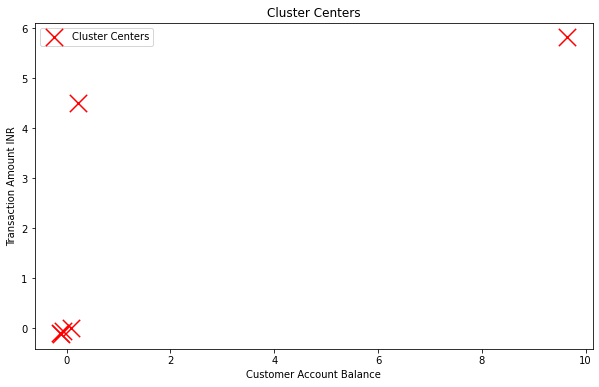

In [39]:
# Visual Represetation
# Get the cluster centers from the model
centers = model.clusterCenters()

# Convert the centers to a Pandas DataFrame for easier plotting
centers_df = pd.DataFrame(centers, columns=feature_columns)

# Plot the cluster centers
plt.figure(figsize=(10, 6))
plt.scatter(centers_df['CustAccountBalance'], centers_df['TransactionAmountINR'], 
            s=300, c='red', marker='x', label='Cluster Centers')
plt.xlabel('Customer Account Balance')
plt.ylabel('Transaction Amount INR')
plt.title('Cluster Centers')
plt.legend()
plt.show()

# Perform Hierarchical Clustering using PySpark k=8

In [40]:
from pyspark.ml.clustering import BisectingKMeans

# Apply BisectingKMeans for hierarchical clustering on the training data
bkmeans = BisectingKMeans(k=8, featuresCol="scaledFeatures", seed=1)
model = bkmeans.fit(train_data)

In [41]:
# Make predictions on the test data
predictions = model.transform(test_data)

In [42]:
# Evaluate clustering by computing Within Set Sum of Squared Errors (WSSSE)
wssse = model.computeCost(test_data)
print(f"Within Set Sum of Squared Errors = {wssse}")

Within Set Sum of Squared Errors = 305029.1065373118


In [43]:
# Show some of the predictions
predictions.select("TransactionID", "CustomerID", "prediction").show(5)

+-------------+----------+----------+
|TransactionID|CustomerID|prediction|
+-------------+----------+----------+
|           T1|  C5841053|         0|
|          T10|  C6638934|         4|
|         T100|  C1713934|         4|
|      T100008|  C8632241|         2|
|      T100020|  C2466557|         4|
+-------------+----------+----------+
only showing top 5 rows



In [44]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score = {silhouette}")

Silhouette Score = 0.22667428887600605


In [45]:
# Silhouette Score = 0.22667428887600605
# means some clusters are little overlapping
# not a really good segmentation

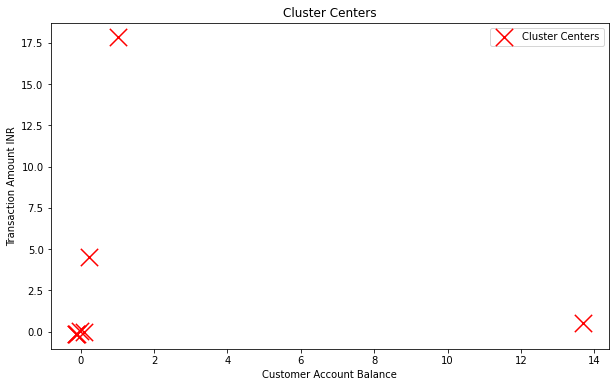

In [46]:
# Visual Represetation
# Get the cluster centers from the model
centers = model.clusterCenters()

# Convert the centers to a Pandas DataFrame for easier plotting
centers_df = pd.DataFrame(centers, columns=feature_columns)

# Plot the cluster centers
plt.figure(figsize=(10, 6))
plt.scatter(centers_df['CustAccountBalance'], centers_df['TransactionAmountINR'], 
            s=300, c='red', marker='x', label='Cluster Centers')
plt.xlabel('Customer Account Balance')
plt.ylabel('Transaction Amount INR')
plt.title('Cluster Centers')
plt.legend()
plt.show()

# Conclusion of Hierarchical Clustering 

#After performing Hierarchical Clustering we found no perfect clustering happening. 
#Within these at k=4 -> Silhouette Score is = 0.3844893147205863~0.4
#means clustering has a moderate level of quality
#Average segmentation

#Because of this we are now performing K-Means Clustering 

# ---------------------------------K-Means Clustering-----------------------------------------

# Initializing Spark and Loading the Dataset

In [50]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col

# Initialize a Spark session
spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

# Load the dataset
df = spark.read.csv("file:///home/talentum/shared/C-DAC_Project/Bank_Transaction_clean.csv", header=True, inferSchema=True)

# Display the first few rows and schema
df.show(5)
df.printSchema()

+-------------+----------+----------+------------------+-------------------+--------------------+-----------+------------+
|TransactionID|CustomerID|CustGender|CustAccountBalance|    TransactionDate|TransactionAmountINR|CustomerAge|CustLocation|
+-------------+----------+----------+------------------+-------------------+--------------------+-----------+------------+
|           T1|  C5841053|         F|          17819.05|2016-08-02 00:00:00|                25.0|         22|  JAMSHEDPUR|
|           T3|  C4417068|         F|          17874.44|2016-08-02 00:00:00|               459.0|         19|      MUMBAI|
|           T4|  C5342380|         F|          866503.2|2016-08-02 00:00:00|              2060.0|         43|      MUMBAI|
|           T5|  C9031234|         F|           6714.43|2016-08-02 00:00:00|              1762.5|         28|      MUMBAI|
|           T6|  C1536588|         F|           53609.2|2016-08-02 00:00:00|               676.0|         44|    ITANAGAR|
+-------------+-

# Feature Selection

In [51]:
# Selecting some features
selected_features = ['CustAccountBalance', 'TransactionAmountINR', 'CustomerAge']  

# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
assembled_data = assembler.transform(df)

# Scale the features (optional but recommended)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

# Split the Data into Training and Test Sets

In [53]:
# Split the data into training and test sets
train_data, test_data = scaled_data.randomSplit([0.8, 0.2], seed=42)

# WSSSE (within-set sum of squared errors)

In [54]:
# List to store WSSSE for each value of k
wssse_list = []

# Test different values of k (e.g., from 2 to 10)
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(featuresCol="scaled_features", k=k)
    model = kmeans.fit(scaled_data)
    wssse = model.summary.trainingCost  # Sum of squared distances to the closest centroid
    wssse_list.append(wssse)
    print(f"Within-Set Sum of Squared Errors (WSSSE) for k={k}: {wssse}")


Within-Set Sum of Squared Errors (WSSSE) for k=2: 2096548.6300761928
Within-Set Sum of Squared Errors (WSSSE) for k=3: 1643582.866898465
Within-Set Sum of Squared Errors (WSSSE) for k=4: 1403410.9483871516
Within-Set Sum of Squared Errors (WSSSE) for k=5: 1079210.6462962301
Within-Set Sum of Squared Errors (WSSSE) for k=6: 1132515.444809998
Within-Set Sum of Squared Errors (WSSSE) for k=7: 883134.4600042363
Within-Set Sum of Squared Errors (WSSSE) for k=8: 785725.2129372198
Within-Set Sum of Squared Errors (WSSSE) for k=9: 611107.3517636681
Within-Set Sum of Squared Errors (WSSSE) for k=10: 600266.4428105312


# implimenting elbow method to know k

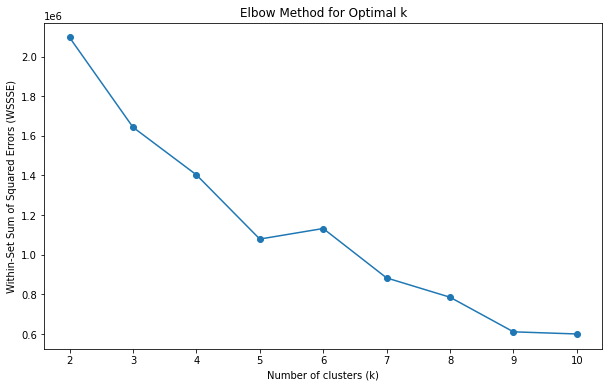

In [55]:
# Plot the WSSSE values against k values to visualize the elbow
plt.figure(figsize=(10, 6))
plt.plot(k_values, wssse_list, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Set Sum of Squared Errors (WSSSE)")
plt.show()

# Apply K-Means Clustering k=6

In [56]:
# Initialize the K-Means model
kmeans = KMeans(featuresCol="scaled_features", k=6)  # Set k (number of clusters)

# Fit the model on the training data
model = kmeans.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

In [57]:
# Evaluate clustering by computing the Silhouette score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score = {silhouette}")

# Optionally, compute the accuracy by comparing predicted clusters with some true labels if available
# This assumes you have a 'label' column in your dataset
if 'label' in df.columns:
    predictions_with_labels = predictions.withColumnRenamed("prediction", "cluster")
    correct_predictions = predictions_with_labels.filter(col("label") == col("cluster")).count()
    total_data = predictions_with_labels.count()
    accuracy = correct_predictions / total_data
    print(f"Accuracy = {accuracy}")

Silhouette score = 0.5186588259761805


# Apply K-Means Clustering k=5

In [62]:
# Initialize the K-Means model
kmeans = KMeans(featuresCol="scaled_features", k=5)  # Set k (number of clusters)

# Fit the model on the training data
model = kmeans.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

In [63]:
# Evaluate clustering by computing the Silhouette score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score = {silhouette}")

# Optionally, compute the accuracy by comparing predicted clusters with some true labels if available
# This assumes you have a 'label' column in your dataset
if 'label' in df.columns:
    predictions_with_labels = predictions.withColumnRenamed("prediction", "cluster")
    correct_predictions = predictions_with_labels.filter(col("label") == col("cluster")).count()
    total_data = predictions_with_labels.count()
    accuracy = correct_predictions / total_data
    print(f"Accuracy = {accuracy}")

Silhouette score = 0.6558622755139676


# graphical representation of clusters

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

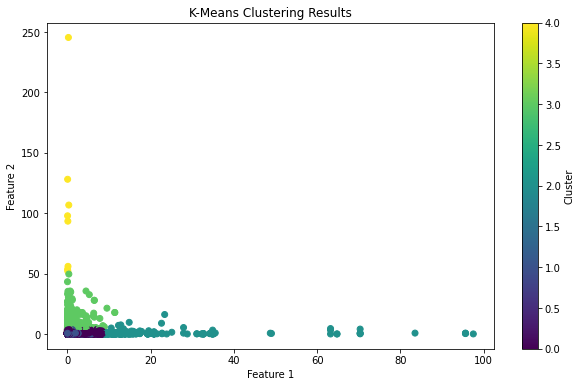

In [65]:
# Convert to pandas DataFrame for visualization
pandas_df = predictions.select("scaled_features", "prediction").toPandas()

# Extract the selected features and the prediction column
# Assume feature1 and feature2 are chosen for 2D plotting (you can select any two features)
feature_vectors = pandas_df["scaled_features"].apply(lambda x: pd.Series(x.toArray()))
pandas_df = pd.concat([feature_vectors, pandas_df["prediction"]], axis=1)
pandas_df.columns = ["feature1", "feature2", "feature3", "prediction"]

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["feature1"], pandas_df["feature2"], c=pandas_df["prediction"], cmap='viridis')
plt.title("K-Means Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster")
plt.show()

# Apply K-Means Clustering k=4

In [60]:
# Initialize the K-Means model
kmeans = KMeans(featuresCol="scaled_features", k=4)  # Set k (number of clusters)

# Fit the model on the training data
model = kmeans.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

In [61]:
# Evaluate clustering by computing the Silhouette score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score = {silhouette}")

# Optionally, compute the accuracy by comparing predicted clusters with some true labels if available
# This assumes you have a 'label' column in your dataset
if 'label' in df.columns:
    predictions_with_labels = predictions.withColumnRenamed("prediction", "cluster")
    correct_predictions = predictions_with_labels.filter(col("label") == col("cluster")).count()
    total_data = predictions_with_labels.count()
    accuracy = correct_predictions / total_data
    print(f"Accuracy = {accuracy}")

Silhouette score = 0.618811636038378


# so, we are deciding that K-Means Clustering ih usefull than Hierarchical Clustering

# In that there are 5 numbers of clusters. Because Silhouette score = 0.6558622755139676